In [ ]:
#Function to convert image into array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir 

In [ ]:
# Please make sure to google below subjects
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import tensorflow

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

For below operation I am taking dataset from google drive please make sure that you have Dataset in your drive if you dont get this contact me.Run below cell to get authorisation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[click](https://datascience.stackexchange.com/questions/29480/uploading-images-folder-from-my-system-into-google-colab) to know how i arrived at this

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3 #https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/PATH_TO_OUTPUT'
width=256
height=256
depth=3

In [ ]:
!unzip -uq "/content/drive/My Drive/Final year project/Dataset" -d "/content/drive/My Drive/PATH_TO_OUTPUT"

In [ ]:
#below code is for processing the images
image_list, label_list = [], []
 
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)
 
    for plant_folder in root_dir : 
        plant_disease_folder_list = listdir(f'{directory_root}/{plant_folder}')
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)
 
        for plant_disease_folder in plant_disease_folder_list:
            print(f'[INFO] Processing {plant_disease_folder} ...')
            plant_disease_image_list = listdir(f'{directory_root}/{plant_folder}/{plant_disease_folder}/')
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)
 
            for image in plant_disease_image_list[:200]:
                image_directory = f'{directory_root}/{plant_folder}/{plant_disease_folder}/{image}'
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Image loading completed


In [ ]:
print(image_list)

[array([[[128., 117., 133.],
        [129., 118., 134.],
        [135., 124., 140.],
        ...,
        [107.,  95., 113.],
        [120., 108., 126.],
        [121., 109., 127.]],

       [[186., 175., 191.],
        [126., 115., 131.],
        [121., 110., 126.],
        ...,
        [111.,  99., 117.],
        [120., 108., 126.],
        [120., 108., 126.]],

       [[120., 109., 125.],
        [161., 150., 166.],
        [126., 115., 131.],
        ...,
        [109.,  97., 115.],
        [115., 103., 121.],
        [116., 104., 122.]],

       ...,

       [[169., 158., 174.],
        [168., 157., 173.],
        [170., 159., 175.],
        ...,
        [197., 182., 196.],
        [141., 126., 140.],
        [150., 135., 149.]],

       [[164., 153., 169.],
        [167., 156., 172.],
        [172., 161., 177.],
        ...,
        [173., 158., 172.],
        [163., 148., 162.],
        [136., 121., 135.]],

       [[146., 135., 151.],
        [154., 143., 159.],
        [166., 

In [ ]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

['Tomato_Bacterial_spot' 'Tomato_Early_blight'
 'Tomato__Tomato_mosaic_virus' 'Tomato_healthy']


In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

[INFO] Spliting data to train, test


In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))

model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))#Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. 

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))

model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

[INFO] training network...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
20/20 [==============================] - 132s 6s/step - loss: 0.8504 - accuracy: 0.6603 - val_loss: 2.0764 - val_accuracy: 0.2688
Epoch 2/25
20/20 [==============================] - 128s 6s/step - loss: 0.2128 - accuracy: 0.9344 - val_loss: 3.0747 - val_accuracy: 0.2688
Epoch 3/25
20/20 [==============================] - 127s 6s/step - loss: 0.1869 - accuracy: 0.9246 - val_loss: 4.1214 - val_accuracy: 0.2688
Epoch 4/25
20/20 [==============================] - 127s 6s/step - loss: 0.1071 - accuracy: 0.9508 - val_loss: 2.0999 - val_accuracy: 0.2688
Epoch 5/25
20/20 [==============================] - 127s 6s/step - loss: 0.1077 - accuracy: 0.9290 - val_loss: 3.2546 - val_accuracy: 0.2688
Epoch 6/25
20/20 [==============================] - 127s 6s/step - loss: 0.0982 - accuracy: 0.9569 - val_loss: 2.5403 - val_accuracy: 0.2688
Epoch 7/25
20/20 [==============================] - 127s 6s/step - loss: 0.1041 - accuracy: 0.9544 - val_loss: 5.2537 - val_accuracy: 0.2688
Epoch 8/25
20

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

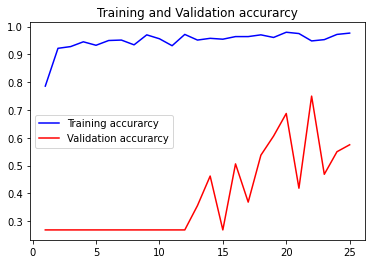

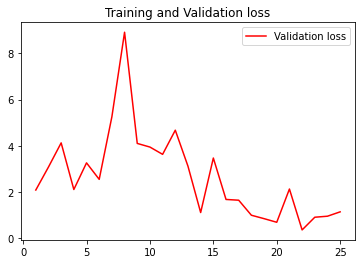

In [ ]:
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
#plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
5/5 [==============================] - 7s 1s/step - loss: 1.1311 - accuracy: 0.5750
Test Accuracy: 57.499998807907104


In [ ]:
model.save("model.h5")

[click](https://intellipaat.com/community/9487/how-to-predict-input-image-using-trained-model-in-keras) to know about how to make use of pre trained model to predict new images.